In [1]:
# Beware of importing these outside of google colab.
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir;
!{sys.executable} -m pip install forked-rompy;

In [2]:
!git clone https://github.com/theorydas/pySurrogate

fatal: destination path 'pySurrogate' already exists and is not an empty directory.


# Initialise Notebook

### Imports

In [3]:
from matplotlib.ticker import AutoMinorLocator, LogLocator
from numpy.random import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import rompy as rp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from scipy.interpolate import UnivariateSpline
from scipy.integrate import trapz, simps
from scipy.fft import fft, fftfreq

from tqdm.notebook import tqdm

from pySurrogate import pySurrogate
from pycbc import waveform

In [4]:
plt.rcParams["xtick.labelsize"] = "large"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 6
plt.rcParams["xtick.major.width"] = 1.2
plt.rcParams["xtick.minor.size"] = 3

plt.rcParams["ytick.labelsize"] = "large"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 6
plt.rcParams["ytick.major.width"] = 1.2
plt.rcParams["ytick.minor.size"] = 3

plt.rcParams["axes.labelsize"] = "x-large"
plt.rcParams["axes.labelpad"] = 6
plt.rcParams["axes.titlesize"] = 17
plt.rcParams["axes.grid"] = True

plt.rcParams["font.family"] = "serif"
plt.rcParams["grid.linestyle"] = "dashed"
plt.rcParams["grid.alpha"] = 0.8

plt.rcParams["figure.facecolor"] = "white"

## Preprocessing

In [5]:
def cropSignalsAtLength(array: list, length: int, isLeftSide: bool = True) -> list:
  """ Crops the waveforms signals to a matching length from either the left or
  right side.
  """
  newWaveforms = []
  
  for amplitude, phi in array:
    if isLeftSide:
      newWaveforms.append( [ amplitude[-length:], phi[-length:] ] )
    else:
      newWaveforms.append( [ amplitude[:length], phi[:length] ] )

  return newWaveforms

def alignPeaks(array: list, peakIndex: int) -> list:
  """ Shifts the waveform vector such that all of the amplitude peaks will happen at the same
  index/time position.
  """
  newWaveforms = []

  for amplitude, phi in array:
    indexDifference = amplitude.argmax() -peakIndex
    newWaveforms.append( np.vstack([ amplitude[indexDifference:], phi[indexDifference:] ]) )

  return newWaveforms

def rotatePhase(array: np.ndarray, phi0: float, indexPosition: int = 0):
  """ Rotates the phases of the waveform vector to match phi0 at indexPoisition.
  """
  arrayLength = len(array[1][1])

  newArray = []
  for amplitude, phi in array:
    phi_ = phi + (phi0 -phi[indexPosition]) *np.ones(len(phi))
    newArray.append( np.vstack([amplitude, phi_]) )
  
  return newArray

def unpackWave(array: np.ndarray):
  """ Returns the amplitude and phase of the packed
  wave array of the form [wave, amplitude].
  """
  amplitude, phase = list(zip(*array))

  return np.array(amplitude), np.array(phase)

def processWaveform(waves, samplingFrequency: int = 4096):
  """ A wrapper function to cleanly condition the waveform data for training.
  The waveform vectors will be aligned in time and then cropped such that the amplitude
  peaks at the same time-bin which is considered t = 0s and the minimum frequency
  of each increases to accommodate same time-length before the peak. Finally the cropped
  phases are rotated such that all start with the same initial conditions.
  """
  # Crop waveforms to aling all peaks at the index of the fastest occuring one.
  l = min([waveform[0, :].argmax() for waveform in waves])
  waves_ = alignPeaks(waves, l)

  # Crop all signals to match the dimensions of the smallest one.
  l = min([len(waveform[0, :]) for waveform in waves_])
  waves_ = cropSignalsAtLength(waves_, l, False)

  # Rotate the phases such that all have phi0 at index indexPosition.
  waves_ = rotatePhase(waves_, phi0 = 1, indexPosition = 0)

  # Finds the index of the waveform with the most trailing zeroes on amplitude
  # and crops all of the waveforms at that point.
  # I find that this helps reduce the greedy basis size while still retaining
  # information up to 2 OoM strain below the initial strain on a wave.
  amplitude, phi = unpackWave(waves_)
  back = np.array([len(np.trim_zeros(am, "b")) for am in amplitude])
  waves_ = cropSignalsAtLength(waves_, int(back.min()), False)

  # Finally unpack the time-domain amplitude and phase and give it a vector form.
  amplitude, phase = unpackWave(waves_)

  amplitude = np.vstack(amplitude)
  phase = np.vstack(phase)

  # Set up a common time frame for the waveforms which is also physical.
  total = len(amplitude[0]) # /samplingFrequency = Total Time of waveforms.
  peak = amplitude[0].argmax() # /samplingFrequency = Custom system where t_peak = 0s.

  t = np.arange(-peak/samplingFrequency, (total -peak)/samplingFrequency, 1/samplingFrequency)

  return t, amplitude, phase

def generateWave(N: int = 1, M = [150, 150], q = [1, 2], s1z = [0, 0], s2z = [0, 0], approximant: str = "SEOBNRv4_opt", verbose = True, f_lower = 10):
  """ A wrapper function to uniformly sample non-precessing gravitational waveforms
  from pyCBC modules.
  """
  M_ = random(N) *(M[1] -M[0]) +M[0] # The sum of masses
  q_ = random(N) *(q[1] -q[0]) +q[0] # Mass ratio
  s1 = random(N) *(s1z[1] -s1z[0]) +s1z[0] # 1st Spin
  s2 = random(N) *(s2z[1] -s2z[0]) +s2z[0] # 2nd Spin
  
  waves = []
  inputParams = np.vstack([q_, M_, s1, s2]).T # Return this vector with all input params at the end.

  iterator = enumerate(inputParams)
  if verbose: iterator = tqdm(iterator)

  for i, (Q, m_tot, S1z, S2z) in iterator:
    M2 = m_tot/(1 +Q)

    try:
      hp, hc = waveform.get_td_waveform(approximant = approximant, mass1 = M2 *Q, mass2 = M2, spin1z = S1z, spin2z = S2z, delta_t = 1.0/4096, f_lower = f_lower)

      # Convert the two polarisations into amplitude and phase vectors
      A = waveform.utils.amplitude_from_polarizations(hp, hc).numpy()
      phi = waveform.utils.phase_from_polarizations(hp, hc).numpy()
    except RuntimeError:
      print("An error has occured at: ", i, " with input: ", Q, m_tot, S1z, S2z)
      inputParams = np.delete(inputParams, i, 0) # Remove problematic input from the parametre vector.
      continue

    waves.append( np.vstack([A, phi]) )
  
  return waves, inputParams

### Calculate Dot Product

In [6]:
def getTemplatePSD(source: str) -> np.array:
  """ Imports PSDs from sources."""
  PSD_Source = {"LIGO": "https://dcc.ligo.org/public/0156/G1801950/001/2017-06-10_DCH_C02_H1_O2_Sensitivity_strain_asd.txt"}

  f, psd = np.loadtxt(PSD_Source[source]).T

  return f, psd

def calculatePSD(f: np.array, detector: str) -> np.array:
  """ Returns the noise curve of the given detector ("White", "LISA"). """
  if detector == "White":
    return np.ones(len(f))
  
  f_, psd = getTemplatePSD(detector)
  sigma = psd.std()
  # Interpolate the data for all interesting frequency values.
  fit = UnivariateSpline(f_, psd/sigma, k = 1, s = 0)

  return fit(f) *sigma

def getFreqDomain(h: np.ndarray, t: np.ndarray, N: int = None, f_min = 0) -> np.ndarray:
  """ Returns the fourier transform h(f) and frequencies of a timeseries h(t). """
  if N is None: N = len(t)

  # Calculate the frequency range of the transformation.
  dT = np.diff(t).mean() # The timestep of the timeseries, equivalent to 1/samplingFrequency
  f = fftfreq(N, dT)[:N//2] # Keep only half values that are positive/physical.

  # Apply FFT to the series itself.
  # The following if, is a quick fix to support vectorisation.
  if h.ndim == 1:
    hf = fft(h, N)[:N//2][f > f_min]
  else:
    hf = fft(h, N)[:, :N//2][:, f > f_min]

  return f[f > f_min], hf

def dotProduct(h1: np.ndarray, h2: np.ndarray, t: np.ndarray, PSD = None) -> np.ndarray:
  """ Calculates the dot product between two complex waveforms over the
  range t in the time domain. If PSD is specified the dot product will be
  calculated in the frequency domain instead.
  
  The product integration uses the simpsons method."""

  if type(PSD) == np.ndarray: # If PSD exists as an array, calculate the freq domain product.
    integral = simps(h1.conj() *h2/PSD, t)

    return 4 *integral.real
  else:
    return simps(h1.conj() *h2, t)
  
def normalizeWaveform(h: np.ndarray, t: np.ndarray, PSD = None) -> np.ndarray:
  """ Normalizes a waveform such that its own dot product is equal to one.
  By defailt, assumes time domain product but if PSD is given calculates in
  the frequency domain."""

  norm = np.sqrt(dotProduct(h, h, t, PSD))
  # Reshape to match vertical vector notation.
  norm = norm.reshape(-1, 1)
  
  return h/norm

def getMismatch(h1: np.array, h2: np.array, t: np.array, detector: str, f_min: float = 9) -> float:
  """ Calculates the mismatch between complex strain waveforms h1 and h2 of the
  time domain given some detector noise curve.
  """
  # Fourier Transform the waveforms
  f, hf1 = getFreqDomain(h1, t, f_min = f_min)
  _, hf2 = getFreqDomain(h2, t, f_min = f_min)
  
  # Choose a noise curve
  PSD = calculatePSD(f, detector)

  # Normalise the waveforms for the given noise.
  hf1 = normalizeWaveform(hf1, f, PSD)
  hf2 = normalizeWaveform(hf2, f, PSD)

  # Calculate the mismatch from definition.
  return 1 -dotProduct(hf1, hf2, f, PSD).real

# Waveform generation & Processing

For this example I will be using the kit to create a fast and accurate numerical relativity (NR) interpolator that generates gravitational waves. Of course, NR simulations require many computational resources and time to be created and datasets are sparse. For the sake of simplicity I will be using the phenomelogical model SEOBNRv4_opt which is accessed by pyCBC and describes sping (anti-)aligned binary systems of mass ratios $q=m1/m2$ in the regime [1, 100] using the effective one body formalism.

Below, I generate randomly sampling a large dataset consisting of strain timeseries, in the mass ratio and spin range where the model is most stable on. All of the waveforms have a sampling frequency of 4096 Hz and start at a minimum frequency of 9 Hz and continue onwards after the merger until some non-relevant cutoff, thus all have a different size from each other. Because of this the output will be a list consisting of #Samples x 2 Polarisations x #TimePoints.

In [7]:
waveforms, _input = generateWave(10000, q = [5, 100], s1z = [-0.8, 0.8], s2z = [-0.8, 0.8])

0it [00:00, ?it/s]

Machine learning algorithms perform better when the input data is well conditioned. Here the waveforms are shifted in time to align their peaks and their phases are rotated at the begining of observation.

In [8]:
t, amplitude, phase = processWaveform(waveforms)

In [9]:
del waveforms

# Project the waveforms into a latent space

Considering that the waveforms are functions of time that require the prediction of multiple time bins at the same time. The predictions of that alone can be very tricky, while if we require a large training sample and a fine resolution to the waveforms, training may bottleneck due to memory issues. Here, to avoid this issues and allow us to train on large samples while also boosting the model convergence in the process a latent space decomposition is deployed that learns to deconstruct and reconstruct the waveform components to and from a few simple numbers.

In this case ROMpy is used which amongst others, provides with a greedy algorithm that constructs a projection base from the dataset with the aim to keep the reconstruction error lower than a certain value.

----

Although data conditioning also allows the regressor to perform better, here this greedy algorithm is also enhanced due to the similarities which were enforced on the dataset after the processing.

In [34]:
integration = rp.Integration([t.min(), t.max()], num = len(t), rule = "trapezoidal")

amp_std = amplitude.std()

# The maximum errors here are chosen to be as acurate as possible while also
# producing a ~small latent space. Coincidently, getting good predictions for the
# phase evolution is more important in reducing parameter estimation bias.
decoder_A, decoder_Phi = rp.Surrogate(integration), rp.Surrogate(integration)
decoder_A.MakeROM(amplitude/amp_std, 0, 1e-10)
decoder_Phi.MakeROM(np.log10(phase), 0, 1e-16)

# Set up the decoder objects that go in the Surrogate object.
surA_decoder = pySurrogate.Decoder(projection_coeffs = decoder_A.ei.data.T, basis = decoder_A.ei.B)
surA_decoder.physicalTransform = lambda x, input: x *amp_std

surPhi_decoder = pySurrogate.Decoder(projection_coeffs = decoder_Phi.ei.data.T, basis = decoder_Phi.ei.B)
surPhi_decoder.physicalTransform = lambda x, input: np.power(10, x)

surA_decoder.getSize(), surPhi_decoder.getSize()

>>> Warning(Index already selected): Exiting greedy algorithm.


(49, 48)

## A look at the decomposed geometry

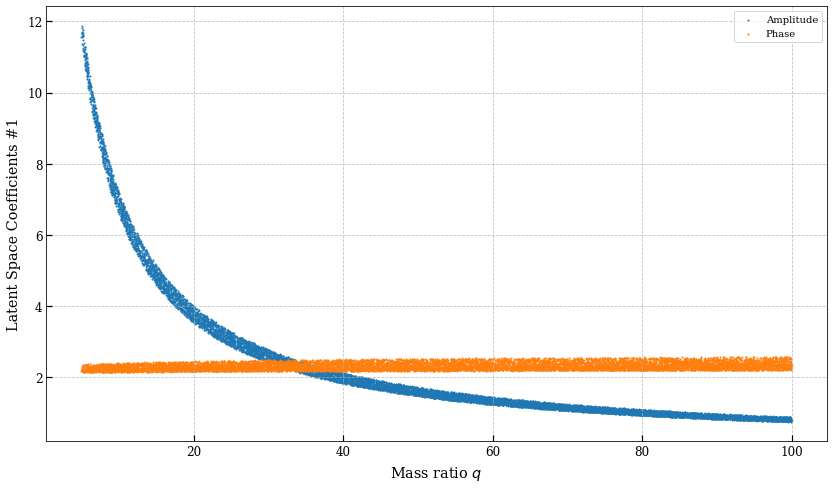

In [35]:
# Looking at the geometry of the decomposed space provides clues to wether fitting
# can be succesful or not, in this case the coefficients for both models are arranged
# in well defined regions with the mass ratio, while lacking other regions in the spins.
plt.figure(figsize = (14, 8))
n = 0

plt.scatter(_input[:, 0], decoder_A.ei.data.T[:, n], s = 1, label = "Amplitude")
plt.scatter(_input[:, 0], decoder_Phi.ei.data.T[:, n], s = 1, label = "Phase")
plt.xlabel("Mass ratio $q$")
plt.ylabel("Latent Space Coefficients #1")
plt.legend()

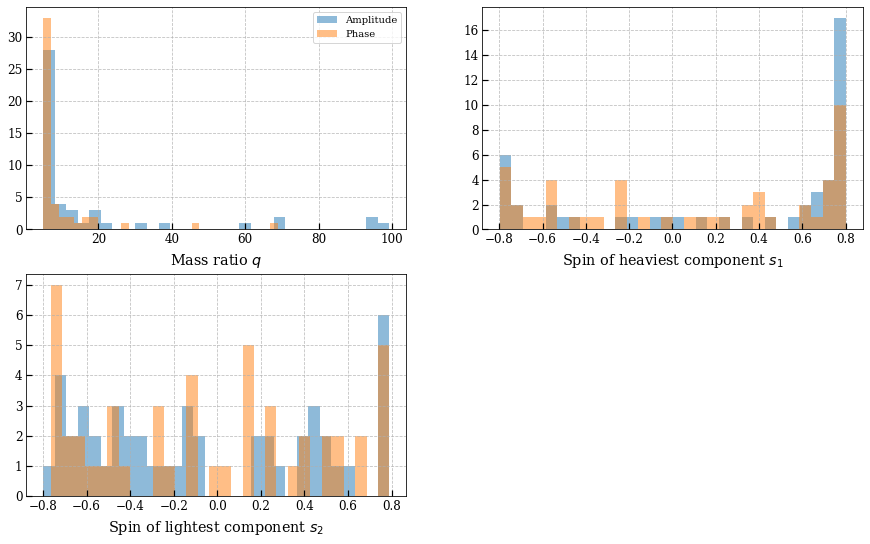

In [36]:
# Interestingly looking at which input the chosen waveforms for the new basis corresponded
# to, reveals that overall low mass ratio and high s1 spins are chosen, which indeed
# relates to these regions featuring the most variation and being the hardest to calculate.
fig, ax = plt.subplots(2, 2, figsize = (15, 9))

ax[0, 0].hist(_input[:, 0][decoder_Phi.rb.indices], alpha = 0.5, bins = 30, label = "Amplitude");
ax[0, 0].hist(_input[:, 0][decoder_A.rb.indices], alpha = 0.5, bins = 30, label = "Phase");
ax[0, 0].set_xlabel("Mass ratio $q$")
ax[0, 0].legend()

ax[0, 1].hist(_input[:, 2][decoder_Phi.rb.indices], alpha = 0.5, bins = 30);
ax[0, 1].hist(_input[:, 2][decoder_A.rb.indices], alpha = 0.5, bins = 30);
ax[0, 1].set_xlabel("Spin of heaviest component $s_1$")

ax[1, 0].hist(_input[:, 3][decoder_Phi.rb.indices], alpha = 0.5, bins = 30);
ax[1, 0].hist(_input[:, 3][decoder_A.rb.indices], alpha = 0.5, bins = 30);
ax[1, 0].set_xlabel("Spin of lightest component $s_2$")

ax[1, 1].remove()

# Set up the input vector

In [37]:
def transformInput(input: np.array) -> np.array:
  """ Transforms the input vector to the desired shape or units for the model. """
  q, M, s1, s2 = input.T

  X = np.vstack([np.log10(q), s1, s2]).T

  return X

# Define the scalers
scalerXA, scalerXPhi, scalerYA, scalerYPhi = StandardScaler(), StandardScaler(), StandardScaler(), StandardScaler()

# Initialize the pySurrogate.Initializer object.
surA_init = pySurrogate.Initializer(transformInput, scalerXA, scalerYA)
surPhi_init = pySurrogate.Initializer(transformInput, scalerXPhi, scalerYPhi)

In [64]:
# Construct the input and output vectors of the model.
X0 = surA_init.inputTranformer(_input)
YA = surA_decoder.projection_coeffs
X, YA = surA_init.fitScalerXY(X0, YA)

# Likewise for the phase surrogate.
YPhi = surPhi_decoder.projection_coeffs
_, YPhi = surPhi_init.fitScalerXY(X0, YPhi)

# Perform a train test split of the data through index splitting.
index = np.arange(len(X)) # Use i_train, i_test to get back other quantities i.e. X_train = X[i_train]
i_train, i_test = train_test_split(index, train_size = 500)

# Gaussian Process Regression

In [65]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel as C

Two independent gaussian process regressors are trained to map the input parameters to the latent space coefficients generated before. A basic combination of kernels is used which are allowed to hypertune themselves before the training process is complete.

In [66]:
kernel = RBF() *C() +WhiteKernel()

GP_A = GaussianProcessRegressor(kernel, alpha = 1e-10, n_restarts_optimizer = 10)
GP_Phi = GaussianProcessRegressor(kernel, alpha = 1e-10, n_restarts_optimizer = 10)

GP_A.fit(X[i_train], YA[i_train])
GP_Phi.fit(X[i_train], YPhi[i_train])

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


GaussianProcessRegressor(kernel=RBF(length_scale=1) * 1**2 + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

At this point two surrogate objects can be created which can be called to get predictions from the input parameters for the phase and amplitude of the waveforms which are then combined to find the strain.

In [67]:
surA_regr = pySurrogate.Regressor(GP_A, GP_A.predict)
surPhi_regr = pySurrogate.Regressor(GP_Phi, GP_Phi.predict)

modelA = pySurrogate.Surrogate(surA_init, surA_decoder, surA_regr)
modelPhi = pySurrogate.Surrogate(surPhi_init, surPhi_decoder, surPhi_regr)

A simple indicator for the quality of the training process of the latent space can be to generate the R2 fitting scores for each model on each dimension of space.

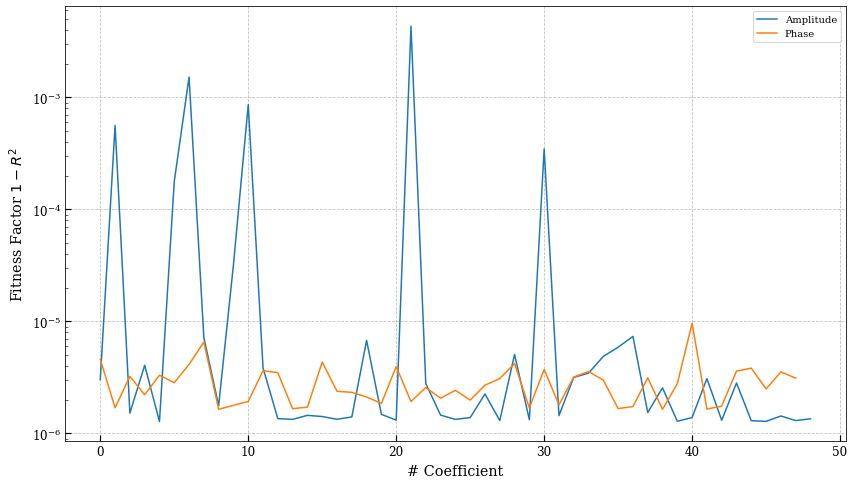

In [68]:
from sklearn.metrics import r2_score

RA = r2_score(YA[i_test], GP_A.predict(X[i_test]), multioutput = "raw_values")
RPhi = r2_score(YPhi[i_test], GP_Phi.predict(X[i_test]), multioutput = "raw_values")

plt.figure(figsize = (14, 8))

plt.plot(1 -RA, label = "Amplitude")
plt.plot(1 -RPhi, label = "Phase")

plt.legend()
plt.ylabel("Fitness Factor $1-R^2$")
plt.xlabel("# Coefficient")
plt.yscale("log")

# Model Efficiency Tests

Let's test how the model performs. We can easily generate data by calling model(input)

In [69]:
A_s = modelA(_input[i_test])
Phi_s = modelPhi(_input[i_test])

# Construct the complex strain waveforms h = hp -i*hc
h = amplitude[i_test] *np.exp(-phase[i_test] *1j)
h_s = A_s *np.exp(-Phi_s *1j)

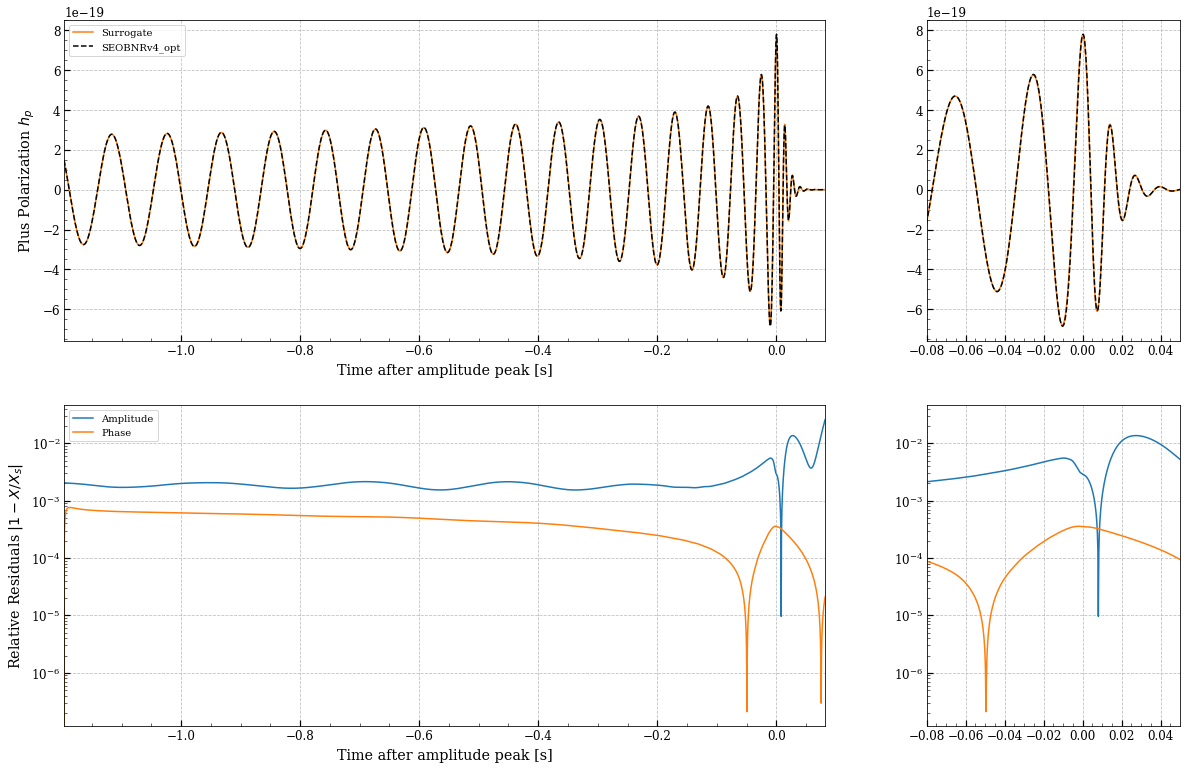

In [70]:
fig, ax = plt.subplots(2, 2, gridspec_kw = {"width_ratios": [3, 1]}, figsize = (20, 13))
ax = ax.flatten()

# Chose which test waveform to depict
n = np.random.randint(1, len(h) +1)

# Plot the strain waveforms.
# plt.suptitle(f" Input Parametres: {input[i_test][n][:3]}, M = {np.log10(getMismatch(h[n].real, h_s[n].real, t, 'White', f_min = 9))[0]}", y = 0.915, size = 17)
ax[0].plot(t, h_s[n].real, markersize = 0, label = "Surrogate", c = "C1")
ax[0].plot(t, h[n].real, markersize = 0, label = "SEOBNRv4_opt", linestyle = "dashed", c = "black")
ax[0].set_xlim(t[1], t[-1])
ax[0].legend()

ax[1].plot(t, h_s[n].real, markersize = 0, c = "C1")
ax[1].plot(t, h[n].real, markersize = 0, linestyle = "dashed",  c = "black")
ax[1].set_xlim(-0.08, 0.05)

ax[0].set_xlabel("Time after amplitude peak [s]")
ax[0].set_ylabel("Plus Polarization $h_p$")
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())

# ------------------------------------------
# Plot the relative differences.
ax[2].plot(t, np.abs(1 -A_s[n]/amplitude[i_test][n]), markersize = 0, label = "Amplitude")
ax[2].plot(t, np.abs(1 -Phi_s[n]/phase[i_test][n]), markersize = 0, label = "Phase")
ax[2].set_xlim(t[1], t[-1])
ax[2].set_yscale("log")
ax[2].legend()

ax[3].plot(t, np.abs(1 -A_s[n]/amplitude[i_test][n]), markersize = 0, label = "Amplitude")
ax[3].plot(t, np.abs(1 -Phi_s[n]/phase[i_test][n]), markersize = 0, label = "Phase")
ax[3].set_xlim(-0.08, 0.05)

ax[2].set_xlabel("Time after amplitude peak [s]")
ax[2].set_ylabel("Relative Residuals $ |1 -X/X_s|$")
ax[2].xaxis.set_minor_locator(AutoMinorLocator())
ax[3].xaxis.set_minor_locator(AutoMinorLocator())
ax[2].yaxis.set_minor_locator(AutoMinorLocator())
ax[3].yaxis.set_minor_locator(AutoMinorLocator())
ax[2].set_yscale("log")
ax[3].set_yscale("log")

## The distribution of residuals

In [71]:
errorsA = np.abs(A_s/amplitude[i_test] -1)
errorsPhi = np.abs(Phi_s - phase[i_test])/(2*np.pi)

errorsA = errorsA.mean(axis = 1)
errorsPhi = errorsPhi.mean(axis = 1)

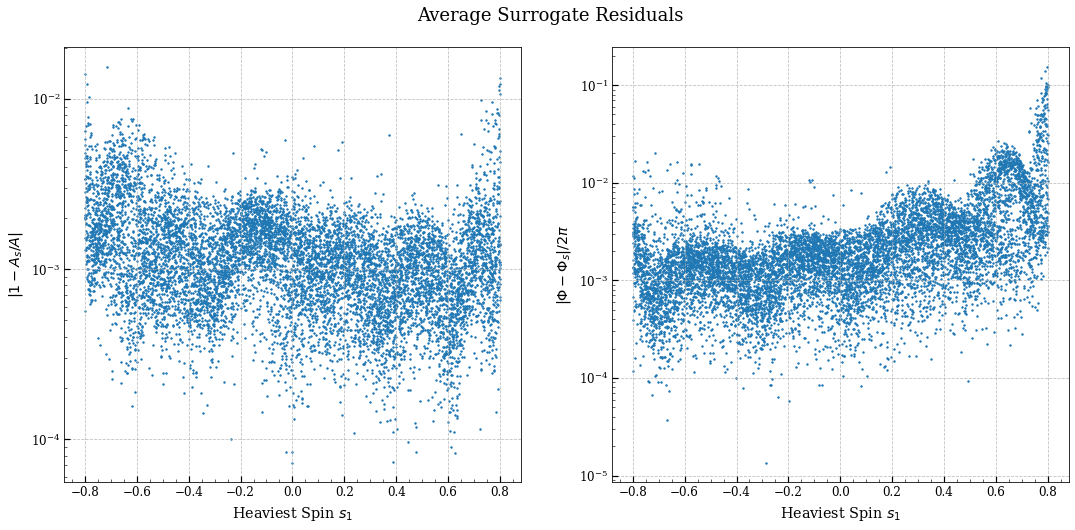

In [72]:
fig, ax = plt.subplots(1, 2, gridspec_kw = {"width_ratios": [1, 1]}, figsize = (18, 8))
n = np.random.randint(1, len(h) +1)
n = 0

plt.suptitle("Average Surrogate Residuals", y = 0.95, size = 18)
ax[0].scatter(_input[i_test][:, 2], errorsA, s = 2)
ax[1].scatter(_input[i_test][:, 2], errorsPhi, s = 2)

ax[0].set_xlabel("Heaviest Spin $s_1$")
ax[1].set_xlabel("Heaviest Spin $s_1$")

ax[0].set_ylabel("$|1 - A_s/A|$")
ax[1].set_ylabel("$|Φ - Φ_s|/2π$")
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())

ax[0].set_yscale("log")
ax[1].set_yscale("log")

## Mismatch Calculation

Mismatch is a popular quantity in the gravitational wave field, which can be understood as a distance/error metric. It is used in parameter estimation to calculate a matching probability for a detection and a template, here the mismatch between the original and the reconstructed waveforms are constructed to provide a clue of how well the model has learned the waveforms, with a perfect match resulting in zero mismatch.

Here we can confidently claim to have created a surrogate model that accurately describes the waveforms with a peak mismatch of 0.1%.

In [73]:
mismatch = getMismatch(h.real, h_s.real, t, "LIGO", f_min = 9)

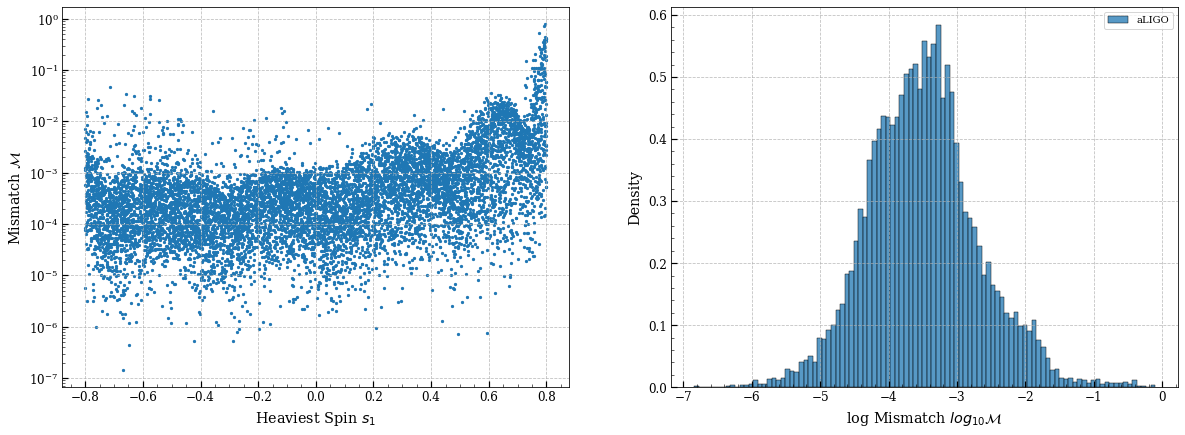

In [74]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

ax[0].scatter(_input[i_test][:, 2], mismatch, s = 5)

ax[0].set_xlabel("Heaviest Spin $s_1$")
ax[0].set_ylabel("Mismatch $\mathcal{M}$")
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].set_yscale("log")

sns.histplot(np.log10(mismatch), bins = 101, stat = "density", label = "aLIGO", ax = ax[1])
ax[1].legend()

ax[1].set_xlabel("log Mismatch $log_{10} \mathcal{M}$")
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())

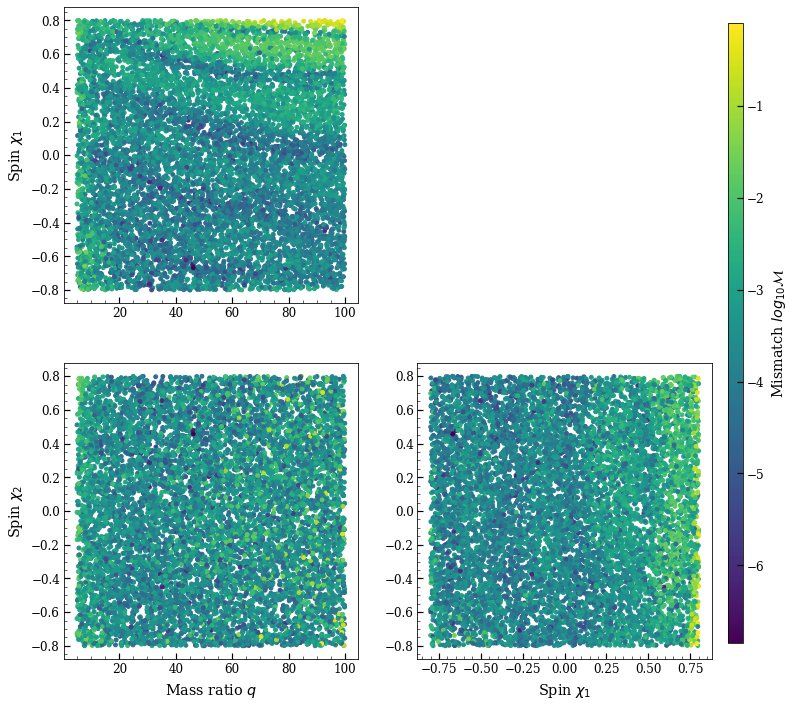

In [75]:
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
ax = ax.flatten()

plotInputs = _input[i_test].copy()
plotInputs = plotInputs[mismatch > 0]
mismatch_ = np.log10(mismatch)[mismatch > 0]

# plt.suptitle(("$\mathcal{M} > 0$"), size = 20, y = 0.92)

ax[0].scatter(plotInputs[:, 0], plotInputs[:, 2], c = mismatch_, s = 15)
ax[0].set_ylabel("Spin $\chi_{1}$")
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].grid()

ax[3].scatter(plotInputs[:, 2], plotInputs[:, 3], c = mismatch_, s = 15)
ax[3].set_xlabel("Spin $\chi_1$")
ax[3].yaxis.set_minor_locator(AutoMinorLocator())
ax[3].xaxis.set_minor_locator(AutoMinorLocator())
ax[3].grid()

ax[2].scatter(plotInputs[:, 0], plotInputs[:, 3], c = mismatch_, s = 15)
ax[2].set_xlabel("Mass ratio $q$")
ax[2].set_ylabel("Spin $\chi_2$")
ax[2].yaxis.set_minor_locator(AutoMinorLocator())
ax[2].xaxis.set_minor_locator(AutoMinorLocator())
ax[2].grid()

cbar_colar = plt.Normalize(mismatch_.min(), mismatch_.max())
cbar_colar = plt.cm.ScalarMappable(cmap = "viridis", norm = cbar_colar)
cbar = fig.colorbar(cbar_colar, ax = ax.ravel().tolist(), shrink = 0.95, pad = 0.02, aspect = 40)
cbar.set_label("Mismatch $log_{10}\mathcal{M}$")


ax[1].remove()
del plotInputs

As evidence for choosing to pay more attention to the phase's deconstruction than the amplitude's, the figures below show the correlation between the average residuals of each component along with the mismatch, revealing a clear correlation in the phase errors.

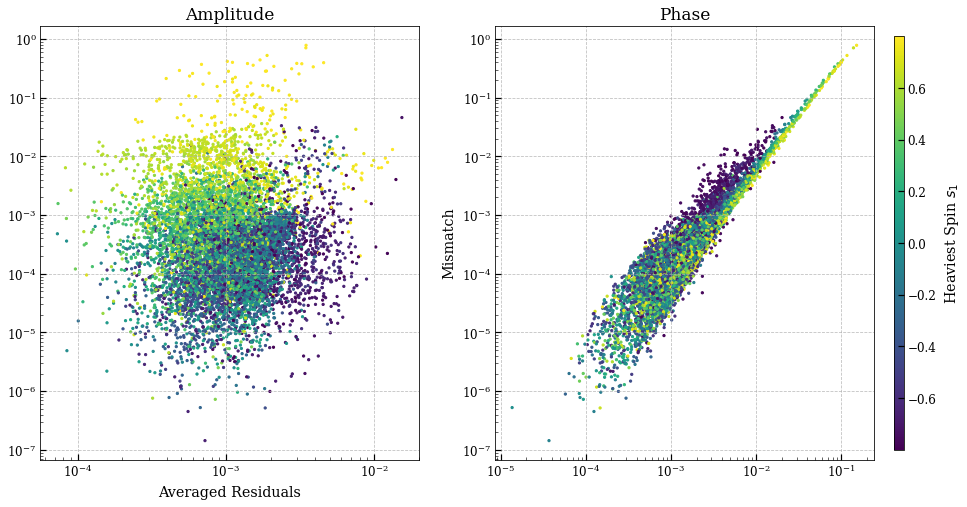

In [76]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))

ax[0].scatter(errorsA, mismatch, s = 5, c = _input[:, 2][i_test])
ax[1].scatter(errorsPhi, mismatch, s = 5, c = _input[:, 0][i_test])
ax[0].set_title("Amplitude")
ax[1].set_title("Phase")

ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_yscale("log")

ax[0].set_xlabel("Averaged Residuals")
ax[0].set_xlabel("Averaged Residuals")
ax[1].set_ylabel("Mismatch")
ax[1].set_ylabel("Mismatch")

cbar_colar = plt.Normalize(_input[:, 2][i_test].min(), _input[:, 2][i_test].max())
cbar_colar = plt.cm.ScalarMappable(cmap = "viridis", norm = cbar_colar)
cbar = fig.colorbar(cbar_colar, ax = ax.ravel().tolist(), shrink = 0.95, pad = 0.02, aspect = 40)
cbar.set_label("Heaviest Spin $s_1$")